# MTH8999 : Analyse des valeurs extrêmes en environnement

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 6 - Extrêmes de suites non stationnaires

Dans cet exemple, les maxima annuels du niveau de la mer (en m) à Fremantle (Australie) sont étudiés.

En plus des variables explicatives utilisées par Coles, j'ai étudié si la température moyenne de la Terre avait un effet significatif sur le niveau.

In [1]:
using CSV, DataFrames, Dates, Distributions, Extremes, Gadfly, StatsBase

In [2]:
"""
    runs_method(data::AbstractVector{<:Real}, u::Real, r::Int)

Estimate the extremal index using the runs method with threshold `u` and runlength `r`

## Details

Parameters:
    - data: Vector of observed values.
    - u: Threshold above which values are considered extreme.
    - r: Run parameter (minimum separation for declustering).

Returns:
    - Estimated extremal index.
"""
function runs_method(data::AbstractVector{<:Real}, u::Real, r::Int)
    
    exceedances = data .> u  # Indicator vector for exceedances
    clusters = 0
    i = 1
    n = length(data)

    while i <= n
        if exceedances[i]
            clusters += 1
            i += r  # Skip ahead by r to decluster
        else
            i += 1
        end
    end

    nu = sum(exceedances)  # Total number of exceedances
    return nu == 0 ? NaN : clusters / nu  # Avoid division by zero
end

"""
    runlength_acf(data::AbstractVector{<:Real}, u::Real, max_lag=10)

Compute the autorcorrelation of the exceeddances above the threshold u
"""
function runlength_acf(data::AbstractVector{<:Real}, u::Real, max_lag=10)
    
    exceedances = data[data .> u]  # Indicator vector
    
    r = 1:max_lag
    
    acf_vals = autocor(exceedances, r)
    
    df = DataFrame(Runlength=r, Correlation = acf_vals)
    
    return df
    
end

"""
    likelihood_ratio_test(M₀, M₁)

Return the p-value of a likelihood ratio test for `MaximumLikelihoodAbstractExtremeValueModel`.

## Detail

`M₀` should be included in `M₁`.

"""
function likelihood_ratio_test(M₀::MaximumLikelihoodAbstractExtremeValueModel, M₁::MaximumLikelihoodAbstractExtremeValueModel)
   
    k₀ = Extremes.nparameter(M₀.model)
    k₁ = Extremes.nparameter(M₁.model)
    
    @assert k₀ < k₁ "Model M₀ should have a lower dimension of model M₁"
    
    k = k₁ - k₀
    
    ℓ₀ = Extremes.loglike(M₀)
    ℓ₁ = Extremes.loglike(M₁)
    
    d = 2*(ℓ₁ - ℓ₀)
    
    pvalue = ccdf(Chisq(k), d)
    
end

likelihood_ratio_test

## 1. Chargement des données et analyse exploratoire

### 1.1 Chargement des maxima annuels du niveau de la mer

In [3]:
data = Extremes.dataset("Fremantle")
last(data, 5)

Row,Year,SeaLevel,SOI
,Int64,Float64,Float64
1,1985,1.57,-0.07
2,1986,1.56,-0.32
3,1987,1.46,-1.47
4,1988,1.7,0.73
5,1989,1.51,0.61


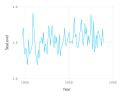

In [4]:
set_default_plot_size(12cm, 10cm)
plot(data, x=:Year, y=:SeaLevel, Geom.line,
    Coord.cartesian(xmin=1895, xmax = 2000))

### 1.2 Chargement de la température moyenne de la Terre

In [5]:
df = CSV.read("temperature-anomaly.csv", DataFrame)
first(df, 5)

Row,Entity,Code,Year,Temperature_anomaly,Lower_bound,Upper_bound
,String31,String15?,Int64,Float64,Float64,Float64
1,Northern Hemisphere,missing,1850,-0.055067,-0.254982,0.144848
2,Northern Hemisphere,missing,1851,0.16158,-0.0475688,0.370729
3,Northern Hemisphere,missing,1852,0.145127,-0.0768596,0.367114
4,Northern Hemisphere,missing,1853,0.135437,-0.0823697,0.353244
5,Northern Hemisphere,missing,1854,0.20614,0.00993872,0.40234


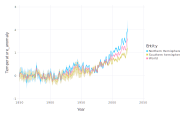

In [6]:
set_default_plot_size(18cm, 12cm)
plot(df, x=:Year, y=:Temperature_anomaly, Geom.line, color=:Entity,
    ymin=:Lower_bound, ymax=:Upper_bound, Geom.ribbon)

In [7]:
# Récupération de l'anomalie globale

filter!(row->row.Entity == "World", df)
rename!(df, :Temperature_anomaly => :Temperature)
select!(df, :Year, :Temperature)
first(df, 5)

Row,Year,Temperature
,Int64,Float64
1,1850,-0.0554137
2,1851,0.128948
3,1852,0.132899
4,1853,0.0919433
5,1854,0.0707769


In [8]:
# Fusion des deux jeux de données

data = innerjoin(data, df, on = :Year)
first(data, 5)

Row,Year,SeaLevel,SOI,Temperature
,Int64,Float64,Float64,Float64
1,1897,1.58,-0.67,0.102498
2,1898,1.71,0.57,-0.123494
3,1899,1.4,0.16,0.0068641
4,1900,1.34,-0.65,0.127804
5,1901,1.43,0.06,0.0688875


## 2. Ajustement des modèles stationnaires et non stationnaires

Pour chacun des modèles considérés, on estime les paramètres avec la libriairie *Extremes.jl*. Cette librairie est particulièrement bien adaptée pour l'estimation des modèles non stationnaires.

Une fois les modèles ajustés, on sélectionne le meilleur avec 
- le test du ratio des vraisemblances (lorsque c'est possible)
- le BIC

**Remarque** : J'ai du remplacer les valeurs initiales par defaut de l'algorithme numérique pour qu'il converge. Habituellement, ce n'est pas nécessaire de remplacer les valeurs par défaut.

### 2.0 Modèle stationnaire

In [9]:
initialvalues = [1.5, 0., 0.]

M₀ = gevfit(data, :SeaLevel, initialvalues)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[86]
	location :	μ ~ 1
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[1.4823423842566676, -1.9570687221672851, -0.2174315877799379]


### 2.1 Localisation en fonction du temps

In [10]:
initialvalues = [1.5, 0., 0., 0.]

M₁ = gevfit(data, :SeaLevel, locationcovid =[:Year], initialvalues)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[86]
	location :	μ ~ 1 + Year
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[-2.472852534530496, 0.0020321955989262594, -2.084851481890028, -0.1253127059499312]


In [11]:
# Test du ratio de vraisemblance 
# Une pvaleur plus petite que 5% indique que le modèle plus complexe est significativement meilleur

pvalue = likelihood_ratio_test(M₀, M₁)

0.00036715082378385624

### 2.2 Localisation en fonction du SOI

In [12]:
initialvalues = [1.5, 0., 0., 0.]

M₂ = gevfit(data, :SeaLevel, locationcovid =[:SOI], initialvalues)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[86]
	location :	μ ~ 1 + SOI
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[1.4898487472904092, 0.061899542749951665, -1.9689417049499665, -0.26849845686357265]


In [13]:
pvalue = likelihood_ratio_test(M₀, M₂)

0.006937719323755415

### 2.3 Localisation en fonction de la température 

In [14]:
initialvalues = [1.5, 0., 0., 0.]

M₃ = gevfit(data, :SeaLevel, locationcovid =[:Temperature], initialvalues)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[86]
	location :	μ ~ 1 + Temperature
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[1.452198628441045, 0.12512091532205533, -2.0004213962498945, -0.16396817559818555]


In [15]:
# Dans ce cas, on trouve que la température n'est pas significative

pvalue = likelihood_ratio_test(M₀, M₃)

0.13801530044598193

### 2.4 Localisation en fonction de la température et du SOI

In [16]:
initialvalues = [1.5, 0., 0., 0., 0.]

M₄ = gevfit(data, :SeaLevel, locationcovid =[:Year, :SOI], initialvalues)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[86]
	location :	μ ~ 1 + Year + SOI
	logscale :	ϕ ~ 1
	shape :		ξ ~ 1

θ̂  :	[-2.625897941619159, 0.0021139833686035442, 0.05451619908877058, -2.114174199543354, -0.1499902665262333]


In [17]:
pvalue = likelihood_ratio_test(M₂, M₄)

0.0002549709486018715

### 2.5 Localisation en fonction de la température et du SOI et échelle fonction du SOI 

In [18]:
initialvalues = [1.5, 0., 0., 0., 0., 0.]

M₅ = gevfit(data, :SeaLevel, locationcovid =[:Year, :SOI], logscalecovid=[:SOI], initialvalues)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[86]
	location :	μ ~ 1 + Year + SOI
	logscale :	ϕ ~ 1 + SOI
	shape :		ξ ~ 1

θ̂  :	[-2.3337944901261456, 0.001966093378379334, 0.06426652941977816, -2.1126401739807372, 0.27262742683121344, -0.18795300142617216]


In [19]:
pvalue = likelihood_ratio_test(M₄, M₅)

0.027742456576224664

### 2.6 Localisation et échelle en fonction de la température et du SOI

In [20]:
initialvalues = [1.5, 0., 0., 0., 0., 0., 0.]

M₆ = gevfit(data, :SeaLevel, locationcovid =[:Year, :SOI], logscalecovid=[:Year, :SOI], initialvalues)

MaximumLikelihoodAbstractExtremeValueModel
model :
	BlockMaxima{GeneralizedExtremeValue}
	data :		Vector{Float64}[86]
	location :	μ ~ 1 + Year + SOI
	logscale :	ϕ ~ 1 + Year + SOI
	shape :		ξ ~ 1

θ̂  :	[-2.2151807037536146, 0.0019067161855639652, 0.06592540576643609, 6.760836543098254, -0.004564833237640996, 0.26511719122686384, -0.22293175789550537]


In [21]:
pvalue = likelihood_ratio_test(M₅, M₆)

0.07505082606117973

## 3. Sélection du meilleur modèle

Avec la procédure du test de ratio de vraisemblance, on trouve que le meilleur modèle est le modèle M₅.

On peut aussi faire la sélection avec le BIC. On trouve le même résultat.

In [22]:
BIC = Extremes.bic.([M₀, M₁, M₂, M₃, M₄, M₅, M₆])

7-element Vector{Float64}:
 -73.77021641701519
 -82.00823813020591
 -76.60489216334693
 -71.51581815764862
 -85.52576317565916
 -85.91541693314386
 -84.63001648908829

In [23]:
argmin(BIC)

6

## 4. Diagnostique du modèle choisi

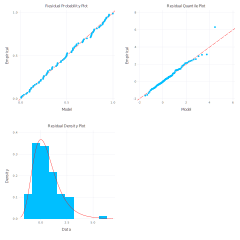

In [24]:
set_default_plot_size(24cm, 24cm)
diagnosticplots(M₅)